In [1]:
import pandas as pd
import json
filePath = r"C:\\Users\\Pat\\Desktop\\Projects\\LoLAramPredictor\\Game Info\\"

In [2]:
with open(filePath+'champion.json', encoding='utf8') as f:
    championData = json.load(f)

champions = pd.DataFrame(columns = ['championId', 'name', 'attack', 'defense', 'magic', 'difficulty', 'primaryClass', 'secondaryClass', 'partype', 'hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed'])

for k, v in championData['data'].items():
    champions = champions.append({'championId': int(v['key']),
                        'name': v['name'], 
                        'attack': v['info']['attack'], 
                        'defense': v['info']['defense'], 
                        'magic': v['info']['magic'], 
                        'difficulty': v['info']['difficulty'], 
                        'primaryClass': v['tags'][0], 
                        'secondaryClass': v['tags'][1] if len(v['tags']) > 1 else 'None', 
                        'partype': v['partype'], 
                        'hp': v['stats']['hp'], 
                        'hpperlevel': v['stats']['hpperlevel'], 
                        'mp': v['stats']['mp'], 
                        'mpperlevel': v['stats']['mpperlevel'], 
                        'movespeed': v['stats']['movespeed'], 
                        'armor': v['stats']['armor'], 
                        'armorperlevel': v['stats']['armorperlevel'], 
                        'spellblock': v['stats']['spellblock'], 
                        'spellblockperlevel': v['stats']['spellblockperlevel'], 
                        'attackrange': v['stats']['attackrange'], 
                        'hpregen': v['stats']['hpregen'], 
                        'hpregenperlevel': v['stats']['hpregenperlevel'], 
                        'mpregen': v['stats']['mpregen'], 
                        'mpregenperlevel': v['stats']['mpregenperlevel'], 
                        'crit': v['stats']['crit'], 
                        'critperlevel': v['stats']['critperlevel'], 
                        'attackdamage': v['stats']['attackdamage'], 
                        'attackdamageperlevel': v['stats']['attackdamageperlevel'], 
                        'attackspeedperlevel': v['stats']['attackspeedperlevel'], 
                        'attackspeed': v['stats']['attackspeed']}, ignore_index=True)

champions

,championId,name,attack,defense,magic,difficulty,primaryClass,secondaryClass,partype,hp,...,hpregen,hpregenperlevel,mpregen,mpregenperlevel,crit,critperlevel,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed
0,266,Aatrox,8,4,3,4,Fighter,Tank,Blood Well,580,...,3,1,0,0,0,0,60,5,2.500,0.651
1,103,Ahri,3,4,8,5,Mage,Assassin,Mana,526,...,6.5,0.6,8,0.8,0,0,53.04,3,2.000,0.668
2,84,Akali,5,3,8,7,Assassin,None,Energy,575,...,8,0.5,50,0,0,0,62.4,3.3,3.200,0.625
3,12,Alistar,6,9,5,7,Tank,Support,Mana,600,...,8.5,0.85,8.5,0.8,0,0,62,3.75,2.125,0.625
4,32,Amumu,2,6,8,3,Tank,Mage,Mana,613.12,...,9,0.85,7.382,0.525,0,0,53.38,3.8,2.180,0.736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,238,Zed,9,2,1,7,Assassin,None,Energy,584,...,7,0.65,50,0,0,0,63,3.4,3.300,0.651
146,115,Ziggs,2,4,9,4,Mage,None,Mana,536,...,6.5,0.6,8,0.8,0,0,54.208,3.1,2.000,0.656
147,26,Zilean,2,5,8,6,Support,Mage,Mana,504,...,5.5,0.5,11.335,0.8,0,0,51.64,3,2.130,0.625
148,142,Zoe,1,7,8,5,Mage,Support,Mana,560,...,6.5,0.6,8,0.65,0,0,58,3.3,2.500,0.625


In [3]:
import asyncpg
import nest_asyncio
import asyncio
from config import dbConfig

nest_asyncio.apply()
loop = asyncio.get_event_loop()

In [4]:
async def fetch_as_dataframe(con: asyncpg.Connection, query: str, *args):
    stmt = await con.prepare(query)
    columns = [a.name for a in stmt.get_attributes()]
    data = await stmt.fetch()
    return pd.DataFrame(data, columns=columns)

async def run():
    connection = await asyncpg.connect(user=dbConfig['user'],
                                password=dbConfig['password'],
                                host=dbConfig['host'],
                                port=dbConfig['port'],
                                database=dbConfig['database'])
    async with connection.transaction():
        avgDPSQuery = f'SELECT "championId", AVG("totalDamageDealtToChampions") as "avgDPS", \
                        percentile_disc(0.25) WITHIN GROUP (ORDER BY "totalDamageDealtToChampions") AS  q1, \
                        percentile_disc(0.5) WITHIN GROUP (ORDER BY "totalDamageDealtToChampions") AS  q2, \
                        percentile_disc(0.75) WITHIN GROUP (ORDER BY "totalDamageDealtToChampions") AS  q3 \
                    FROM "Participant_Stats" \
                    GROUP BY "championId"\
                    ORDER BY "avgDPS"  DESC'
        avgDPS_df = await fetch_as_dataframe(connection, avgDPSQuery)

    return avgDPS_df

avgDPS_df = loop.run_until_complete(run())

avgDPS_df['championId'] = avgDPS_df['championId'].astype(int)
avgDPS_df['avgDPS'] = avgDPS_df['avgDPS'].astype(float)
avgDPS_df = avgDPS_df.merge(champions[['championId','name']], on='championId')

In [5]:
avgDPS_df['avgDPS'].describe()

count      150.000000
mean     21536.734702
std       4727.764126
min       8752.564015
25%      18938.197964
50%      22121.804289
75%      24809.252564
max      33935.785055
Name: avgDPS, dtype: float64

In [6]:
avgDPS_df.head()

,championId,avgDPS,q1,q2,q3,name
0,30,33935.785055,22726,31586,42545,Karthus
1,96,30546.165672,20576,28436,38196,Kog'Maw
2,101,29926.770147,20977,27953,36669,Xerath
3,81,29487.672483,19585,27527,37242,Ezreal
4,74,29234.888463,18896,26617,36662,Heimerdinger


In [7]:
avgDPS_df.loc[avgDPS_df['avgDPS'] <=  avgDPS_df['avgDPS'].quantile(0.5)]

,championId,avgDPS,q1,q2,q3,name
75,25,22120.897454,14678,20425,27635,Morgana
76,56,21958.126087,15082,20465,27235,Nocturne
77,36,21899.514845,14380,20097,27542,Dr. Mundo
78,2,21879.115301,14556,20138,27271,Olaf
79,75,21834.296818,13947,20120,27837,Nasus
...,...,...,...,...,...,...
145,427,11037.789815,7121,10085,13830,Ivern
146,497,10761.179832,6961,9740,13333,Rakan
147,201,10045.223400,6647,9324,12637,Braum
148,117,9708.502997,5563,8348,12207,Lulu


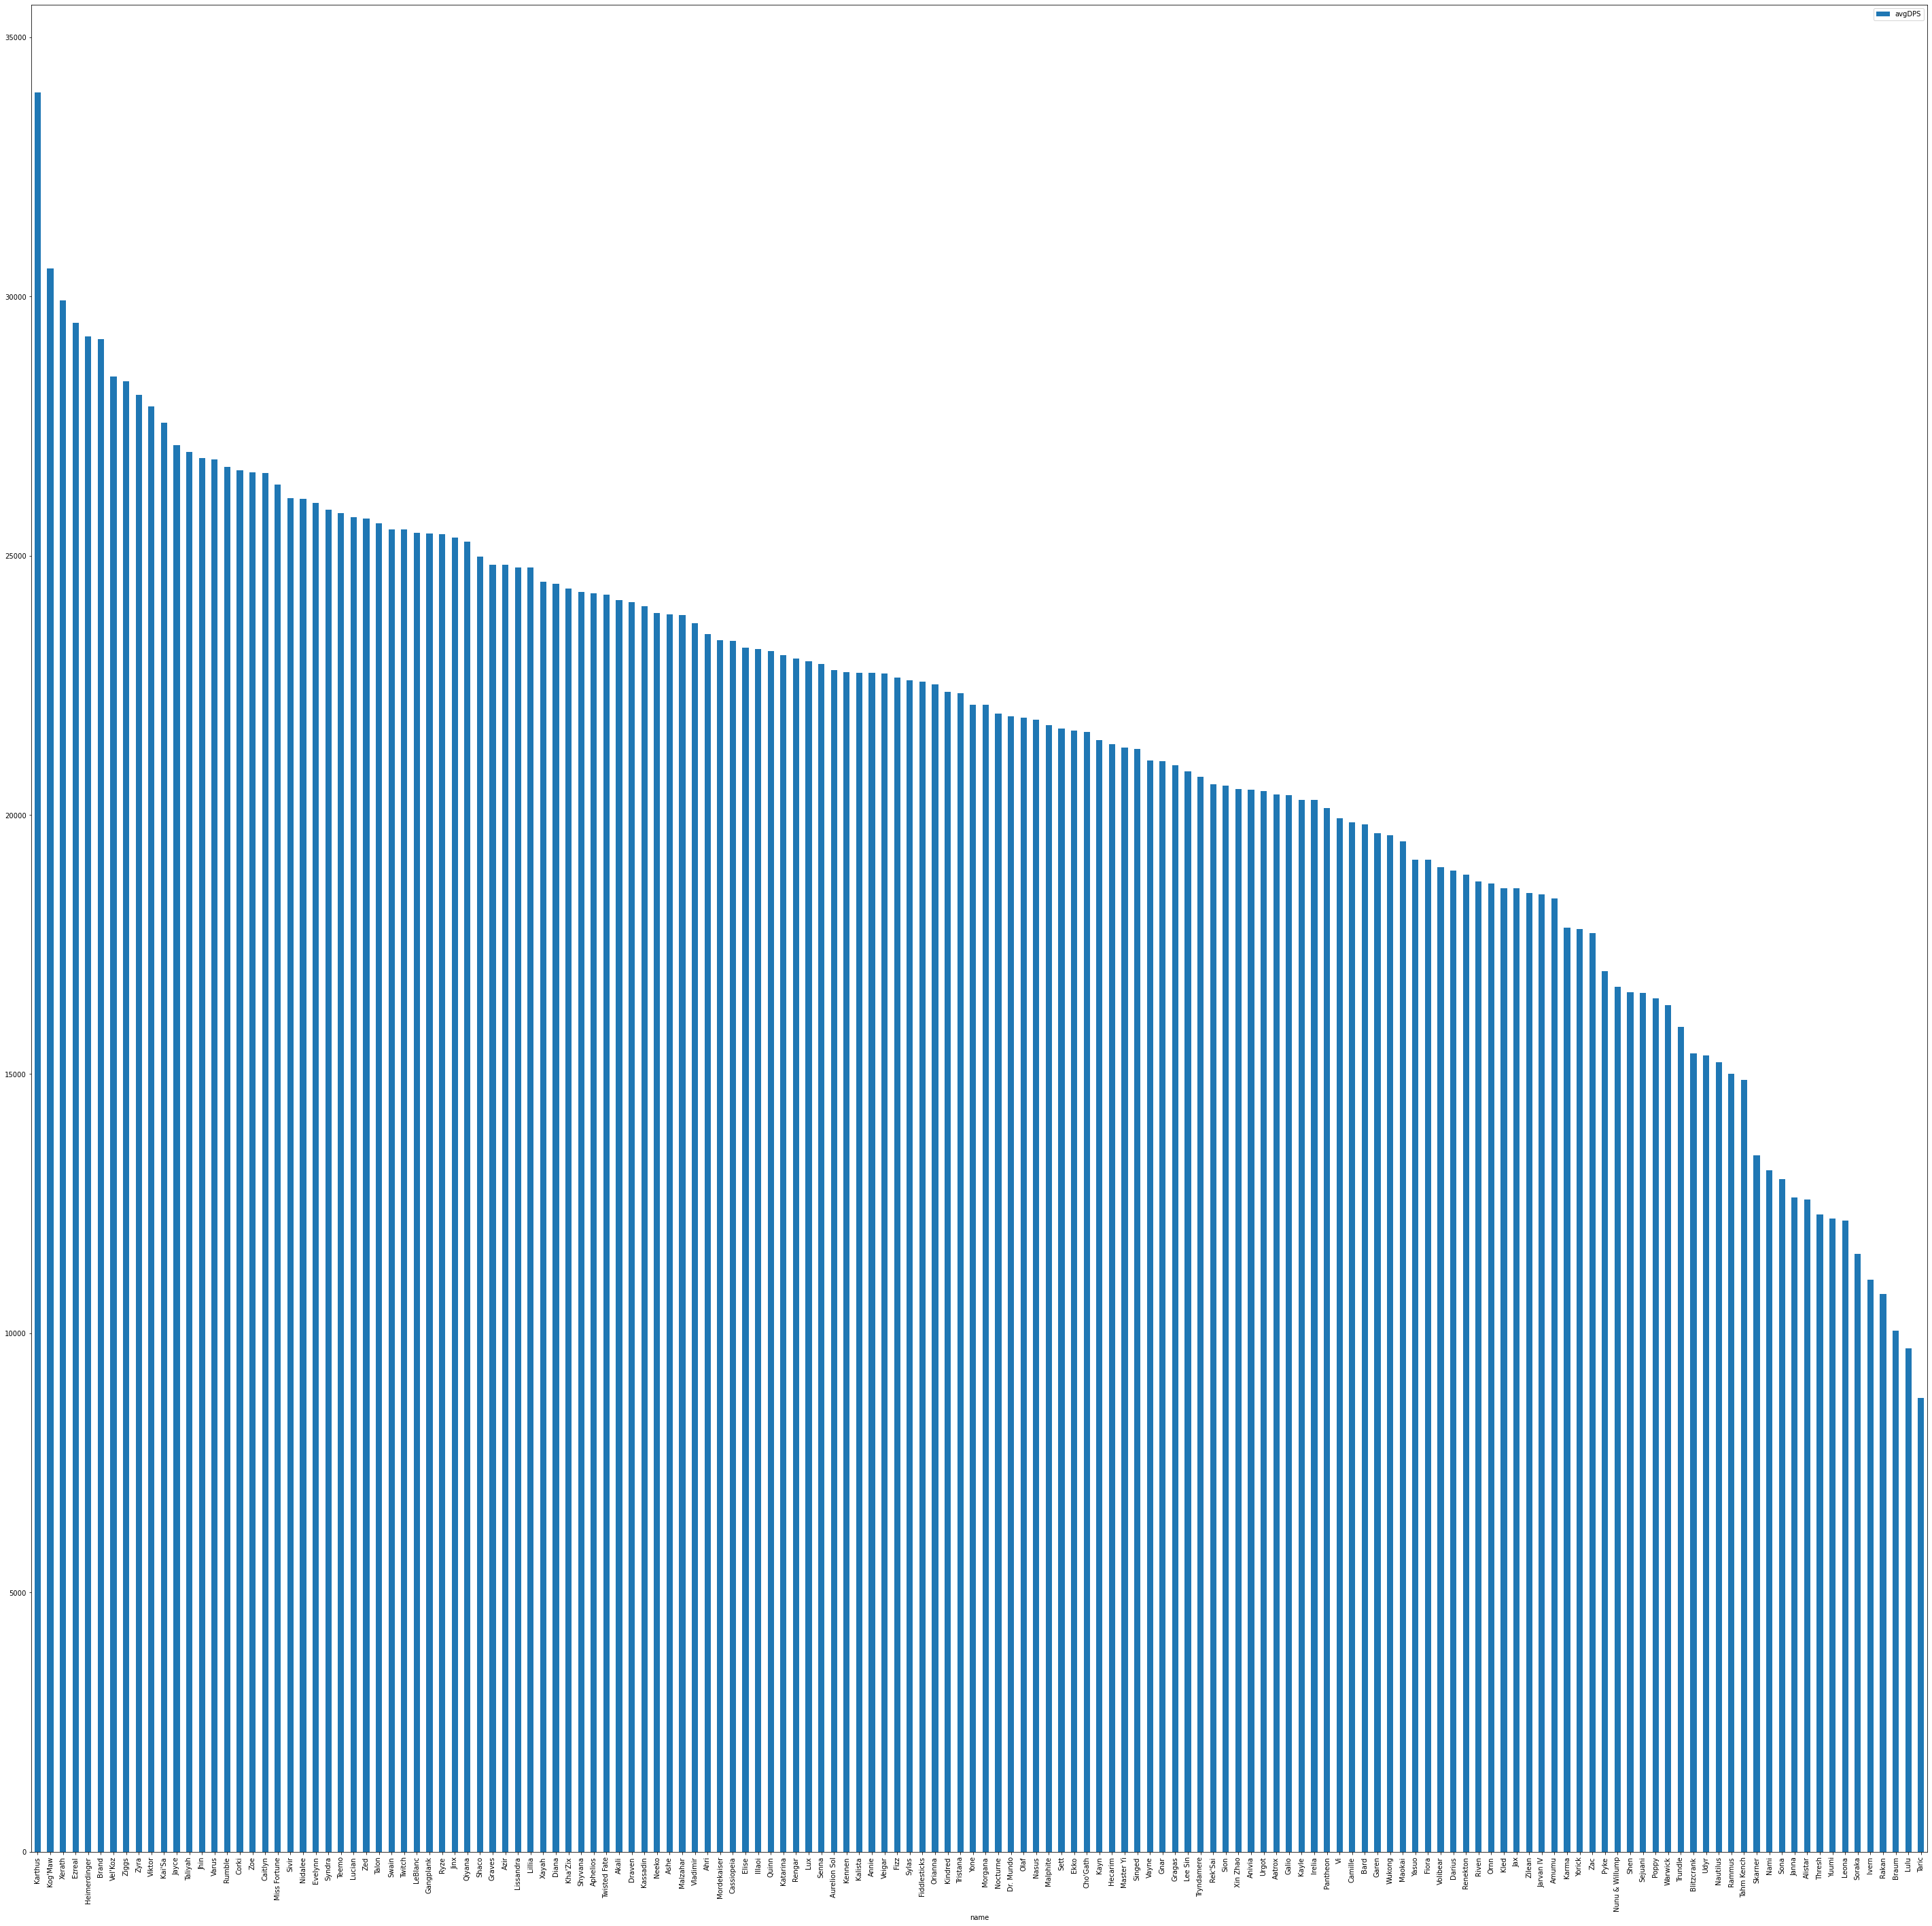

In [8]:
import matplotlib
ax = avgDPS_df[['name', 'avgDPS']].plot.bar(x='name', y='avgDPS', figsize=(50,50))

In [9]:
# noDPSChampName = avgDPS_df.tail(60)['name'].to_list()
# noDPSChampId = avgDPS_df.tail(60)['championId'].to_list()
noDPSq1 = avgDPS_df.loc[avgDPS_df['avgDPS'] <=  avgDPS_df['avgDPS'].quantile(0.25), ['name', 'championId']]
noDPSq2 = avgDPS_df.loc[avgDPS_df['avgDPS'] <=  avgDPS_df['avgDPS'].quantile(0.5), ['name', 'championId']]
noDPSChampIdq1 = noDPSq1['championId'].to_list()
noDPSChampIdq2 = noDPSq2['championId'].to_list()
# print(f'noDPSChampId = {noDPSChampId}')
print(f'noDPSChampNameQ1 = {noDPSq1["name"].to_list()}')
print(f'noDPSChampNameQ2 = {noDPSq2["name"].to_list()}')
print(f'noDPSChampIsQ2 = {noDPSChampIdq2}')

noDPSChampNameQ1 = ['Darius', 'Renekton', 'Riven', 'Ornn', 'Kled', 'Jax', 'Zilean', 'Jarvan IV', 'Amumu', 'Karma', 'Yorick', 'Zac', 'Pyke', 'Nunu & Willump', 'Shen', 'Sejuani', 'Poppy', 'Warwick', 'Trundle', 'Blitzcrank', 'Udyr', 'Nautilus', 'Rammus', 'Tahm Kench', 'Skarner', 'Nami', 'Sona', 'Janna', 'Alistar', 'Thresh', 'Yuumi', 'Leona', 'Soraka', 'Ivern', 'Rakan', 'Braum', 'Lulu', 'Taric']
noDPSChampNameQ2 = ['Morgana', 'Nocturne', 'Dr. Mundo', 'Olaf', 'Nasus', 'Malphite', 'Sett', 'Ekko', "Cho'Gath", 'Kayn', 'Hecarim', 'Master Yi', 'Singed', 'Vayne', 'Gnar', 'Gragas', 'Lee Sin', 'Tryndamere', "Rek'Sai", 'Sion', 'Xin Zhao', 'Anivia', 'Urgot', 'Aatrox', 'Galio', 'Kayle', 'Irelia', 'Pantheon', 'Vi', 'Camille', 'Bard', 'Garen', 'Wukong', 'Maokai', 'Yasuo', 'Fiora', 'Volibear', 'Darius', 'Renekton', 'Riven', 'Ornn', 'Kled', 'Jax', 'Zilean', 'Jarvan IV', 'Amumu', 'Karma', 'Yorick', 'Zac', 'Pyke', 'Nunu & Willump', 'Shen', 'Sejuani', 'Poppy', 'Warwick', 'Trundle', 'Blitzcrank', 'Udyr', 'Nau

In [10]:
async def run():
    connection = await asyncpg.connect(user=dbConfig['user'],
                                password=dbConfig['password'],
                                host=dbConfig['host'],
                                port=dbConfig['port'],
                                database=dbConfig['database'])
    async with connection.transaction():
        drMundoQuery = f'SELECT "gameId", "championId", "teamColor", "win" \
                    FROM "Participant_Stats" \
                    WHERE "gameId" = ANY( \
                        (SELECT array (SELECT "gameId" FROM "Participant_Stats"\
                                        WHERE "championId" = {champions.loc[champions["name"] == "Dr. Mundo", "championId"].values[0]} \
                                        ) \
                                        )::BIGINT[] \
                                        ) \
                    ORDER BY "gameId" ASC;'
        drMundoGames_df = await fetch_as_dataframe(connection, drMundoQuery)
    return drMundoGames_df

drMundoGames_df = loop.run_until_complete(run())
drMundoGames_df

,gameId,championId,teamColor,win
0,2856722469,4,Red,True
1,2856722469,432,Blue,False
2,2856722469,36,Red,True
3,2856722469,83,Red,True
4,2856722469,202,Red,True
...,...,...,...,...
940065,3587800158,51,Blue,False
940066,3587800158,133,Red,True
940067,3587800158,30,Red,True
940068,3587800158,498,Blue,False


In [11]:
drMundoChampId = champions.loc[champions["name"] == "Dr. Mundo", "championId"].values[0]
temp = drMundoGames_df[drMundoGames_df['championId'] == drMundoChampId]
temp['isMundoTeam'] = True
temp

,gameId,championId,teamColor,win,isMundoTeam
2,2856722469,36,Red,True,True
16,2857171698,36,Red,False,True
25,2857258755,36,Red,True,True
30,2857274348,36,Blue,False,True
44,2857851811,36,Red,False,True
...,...,...,...,...,...
940027,3587720418,36,Blue,True,True
940036,3587739162,36,Red,False,True
940048,3587748660,36,Red,False,True
940050,3587792288,36,Red,True,True


In [12]:
drMundoGames_df = pd.merge(drMundoGames_df, temp[['gameId', 'teamColor', 'isMundoTeam']], how='left', left_on=['gameId', 'teamColor'], right_on=['gameId', 'teamColor']).fillna(False)
drMundoGames_df

,gameId,championId,teamColor,win,isMundoTeam
0,2856722469,4,Red,True,True
1,2856722469,432,Blue,False,False
2,2856722469,36,Red,True,True
3,2856722469,83,Red,True,True
4,2856722469,202,Red,True,True
...,...,...,...,...,...
940065,3587800158,51,Blue,False,True
940066,3587800158,133,Red,True,False
940067,3587800158,30,Red,True,False
940068,3587800158,498,Blue,False,True


In [13]:
drMundoGames_df['isLowDPSQ1'] = drMundoGames_df.apply(lambda x: True if x['championId'] in noDPSChampIdq1 else False, axis=1)
drMundoGames_df['isLowDPSQ2'] = drMundoGames_df.apply(lambda x: True if x['championId'] in noDPSChampIdq2 else False, axis=1)

noDPSq1Games = drMundoGames_df.loc[(drMundoGames_df['isMundoTeam'] == False) & (drMundoGames_df['isLowDPSQ1'] == True)]
noDPSq2Games = drMundoGames_df.loc[(drMundoGames_df['isMundoTeam'] == False) & (drMundoGames_df['isLowDPSQ2'] == True)]
noDPSq2Games

,gameId,championId,teamColor,win,isMundoTeam,isLowDPSQ1,isLowDPSQ2
1,2856722469,432,Blue,False,False,False,True
5,2856722469,497,Blue,False,False,True,True
6,2856722469,6,Blue,False,False,False,True
8,2856722469,254,Blue,False,False,False,True
10,2857171698,34,Blue,True,False,False,True
...,...,...,...,...,...,...,...
940049,3587748660,43,Blue,True,False,True,True
940052,3587792288,150,Blue,False,False,False,True
940053,3587792288,79,Blue,False,False,False,True
940063,3587800158,33,Red,True,False,True,True


In [14]:
noDPSq1Games = noDPSq1Games[['gameId', 'win', 'isLowDPSQ1']].groupby(['gameId']).agg(['sum'])[['win', 'isLowDPSQ1']]
noDPSq2Games = noDPSq2Games[['gameId', 'win', 'isLowDPSQ2']].groupby(['gameId']).agg(['sum'])[['win', 'isLowDPSQ2']]
noDPSq1Games.columns = noDPSq1Games.columns.map('_'.join)
noDPSq2Games.columns = noDPSq2Games.columns.map('_'.join)
noDPSq1Games = noDPSq1Games.reset_index()
noDPSq2Games = noDPSq2Games.reset_index()

# noDPSq1Games[noDPSq1Games['isLowDPSQ1_sum'] == 5]

In [15]:
from statsmodels.stats.proportion import proportion_confint

In [16]:
oneLowDPS = noDPSq2Games[noDPSq2Games['isLowDPSQ2_sum'] == 1]
twoLowDPS = noDPSq2Games[noDPSq2Games['isLowDPSQ2_sum'] == 2]
threeLowDPS = noDPSq2Games[noDPSq2Games['isLowDPSQ2_sum'] == 3]
fourLowDPS = noDPSq2Games[noDPSq2Games['isLowDPSQ2_sum'] == 4]
fiveLowDPS = noDPSq2Games[noDPSq2Games['isLowDPSQ2_sum'] == 5]

oneLowDPSWR = oneLowDPS['win_sum'].astype(bool).sum(axis=0)/len(oneLowDPS.index)
twoLowDPSWR = twoLowDPS['win_sum'].astype(bool).sum(axis=0)/len(twoLowDPS.index)
threeLowDPSWR = threeLowDPS['win_sum'].astype(bool).sum(axis=0)/len(threeLowDPS.index)
fourLowDPSWR = fourLowDPS['win_sum'].astype(bool).sum(axis=0)/len(fourLowDPS.index)
fiveLowDPSWR = fiveLowDPS['win_sum'].astype(bool).sum(axis=0)/len(fiveLowDPS.index)

oneLowDPSCI = proportion_confint(oneLowDPS['win_sum'].astype(bool).sum(axis=0), len(oneLowDPS.index), method='binom_test', alpha=0.05)
twoLowDPSCI = proportion_confint(twoLowDPS['win_sum'].astype(bool).sum(axis=0), len(twoLowDPS.index), method='binom_test', alpha=0.05)
threeLowDPSCI = proportion_confint(threeLowDPS['win_sum'].astype(bool).sum(axis=0), len(threeLowDPS.index), method='binom_test', alpha=0.05)
fourLowDPSCI = proportion_confint(fourLowDPS['win_sum'].astype(bool).sum(axis=0), len(fourLowDPS.index), method='binom_test', alpha=0.05)
fiveLowDPSCI = proportion_confint(fiveLowDPS['win_sum'].astype(bool).sum(axis=0), len(fiveLowDPS.index), method='binom_test', alpha=0.05)

In [17]:
print(f"oneLowDPSWR: {oneLowDPSWR:.5f} [{oneLowDPS['win_sum'].astype(bool).sum(axis=0)} / {len(oneLowDPS.index)}]")
print(f"twoLowDPSWR: {twoLowDPSWR:.5f} [{twoLowDPS['win_sum'].astype(bool).sum(axis=0)} / {len(twoLowDPS.index)}]")
print(f"threeLowDPSWR: {threeLowDPSWR:.5f} [{threeLowDPS['win_sum'].astype(bool).sum(axis=0)} / {len(threeLowDPS.index)}]")
print(f"fourLowDPSWR: {fourLowDPSWR:.5f} [{fourLowDPS['win_sum'].astype(bool).sum(axis=0)} / {len(fourLowDPS.index)}]")
print(f"fiveLowDPSWR: {fiveLowDPSWR:.5f} [{fiveLowDPS['win_sum'].astype(bool).sum(axis=0)} / {len(fiveLowDPS.index)}]")

oneLowDPSWR: 0.46264 [9975 / 21561]
twoLowDPSWR: 0.47908 [16650 / 34754]
threeLowDPSWR: 0.47645 [11686 / 24527]
fourLowDPSWR: 0.45737 [3514 / 7683]
fiveLowDPSWR: 0.41714 [365 / 875]


In [18]:
print(f"95% CI: [{oneLowDPSCI[0]:.6f}, {oneLowDPSCI[1]:.6f}]")
print(f"95% CI: [{twoLowDPSCI[0]:.6f}, {twoLowDPSCI[1]:.6f}]")
print(f"95% CI: [{threeLowDPSCI[0]:.6f}, {threeLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fourLowDPSCI[0]:.6f}, {fourLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fiveLowDPSCI[0]:.6f}, {fiveLowDPSCI[1]:.6f}]")

95% CI: [0.455985, 0.469319]
95% CI: [0.473830, 0.484347]
95% CI: [0.470196, 0.482713]
95% CI: [0.446243, 0.468566]
95% CI: [0.384531, 0.450269]


In [19]:
oneLowDPSWR = (~oneLowDPS['win_sum'].astype(bool)).sum(axis=0)/len(oneLowDPS.index)
twoLowDPSWR = (~twoLowDPS['win_sum'].astype(bool)).sum(axis=0)/len(twoLowDPS.index)
threeLowDPSWR = (~threeLowDPS['win_sum'].astype(bool)).sum(axis=0)/len(threeLowDPS.index)
fourLowDPSWR = (~fourLowDPS['win_sum'].astype(bool)).sum(axis=0)/len(fourLowDPS.index)
fiveLowDPSWR = (~fiveLowDPS['win_sum'].astype(bool)).sum(axis=0)/len(fiveLowDPS.index)

oneLowDPSCI = proportion_confint((~oneLowDPS['win_sum'].astype(bool)).sum(axis=0), len(oneLowDPS.index), method='binom_test', alpha=0.05)
twoLowDPSCI = proportion_confint((~twoLowDPS['win_sum'].astype(bool)).sum(axis=0), len(twoLowDPS.index), method='binom_test', alpha=0.05)
threeLowDPSCI = proportion_confint((~threeLowDPS['win_sum'].astype(bool)).sum(axis=0), len(threeLowDPS.index), method='binom_test', alpha=0.05)
fourLowDPSCI = proportion_confint((~fourLowDPS['win_sum'].astype(bool)).sum(axis=0), len(fourLowDPS.index), method='binom_test', alpha=0.05)
fiveLowDPSCI = proportion_confint((~fiveLowDPS['win_sum'].astype(bool)).sum(axis=0), len(fiveLowDPS.index), method='binom_test', alpha=0.05)

In [20]:
print(f"oneLowDPSWR: {oneLowDPSWR:.5f} [{(~oneLowDPS['win_sum'].astype(bool)).sum(axis=0)} / {len(oneLowDPS.index)}]")
print(f"twoLowDPSWR: {twoLowDPSWR:.5f} [{(~twoLowDPS['win_sum'].astype(bool)).sum(axis=0)} / {len(twoLowDPS.index)}]")
print(f"threeLowDPSWR: {threeLowDPSWR:.5f} [{(~threeLowDPS['win_sum'].astype(bool)).sum(axis=0)} / {len(threeLowDPS.index)}]")
print(f"fourLowDPSWR: {fourLowDPSWR:.5f} [{(~fourLowDPS['win_sum'].astype(bool)).sum(axis=0)} / {len(fourLowDPS.index)}]")
print(f"fiveLowDPSWR: {fiveLowDPSWR:.5f} [{(~fiveLowDPS['win_sum'].astype(bool)).sum(axis=0)} / {len(fiveLowDPS.index)}]")

oneLowDPSWR: 0.53736 [11586 / 21561]
twoLowDPSWR: 0.52092 [18104 / 34754]
threeLowDPSWR: 0.52355 [12841 / 24527]
fourLowDPSWR: 0.54263 [4169 / 7683]
fiveLowDPSWR: 0.58286 [510 / 875]


In [21]:
print(f"95% CI: [{oneLowDPSCI[0]:.6f}, {oneLowDPSCI[1]:.6f}]")
print(f"95% CI: [{twoLowDPSCI[0]:.6f}, {twoLowDPSCI[1]:.6f}]")
print(f"95% CI: [{threeLowDPSCI[0]:.6f}, {threeLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fourLowDPSCI[0]:.6f}, {fourLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fiveLowDPSCI[0]:.6f}, {fiveLowDPSCI[1]:.6f}]")

95% CI: [0.530681, 0.544015]
95% CI: [0.515653, 0.526170]
95% CI: [0.517287, 0.529804]
95% CI: [0.531434, 0.553757]
95% CI: [0.549731, 0.615469]


In [22]:
async def run():
    connection = await asyncpg.connect(user=dbConfig['user'],
                                password=dbConfig['password'],
                                host=dbConfig['host'],
                                port=dbConfig['port'],
                                database=dbConfig['database'])
    async with connection.transaction():
        lowDPSQuery = f'SELECT "gameId", "summonerName", "championId", "teamColor", "win" \
                    FROM "Participant_Stats" \
                    WHERE "championId" IN ({" ,".join(str(id) for id in noDPSChampIdq2)}) \
                    ORDER BY "gameId" ASC;'
        lowDPSGames_df = await fetch_as_dataframe(connection, lowDPSQuery)

    return lowDPSGames_df
# champions.loc[champions["name"] == "Amumu", "key"].values[0]
lowDPSGames_df = loop.run_until_complete(run())
lowDPSGames_df.head(20)

,gameId,summonerName,championId,teamColor,win
0,2855142709,MrCaretaker,75,Blue,False
1,2855142709,Facehax,20,Blue,False
2,2855142709,wildhunts,267,Red,True
3,2855142709,Cheesely,57,Red,True
4,2855142709,majinmajor,122,Blue,False
5,2855142709,MrBinky77,117,Red,True
6,2856401827,GotNoNameSkillS,2,Blue,True
7,2856401827,llewechr000,11,Blue,True
8,2856401827,bestballerver,37,Blue,True
9,2856401827,MethTookMyTeeth,10,Red,False


In [23]:
lowDPSGames = lowDPSGames_df[['gameId', 'teamColor', 'win']].groupby(['gameId', 'teamColor']).agg(['sum', 'count'])['win']
lowDPSGames[lowDPSGames['count'] == 5]

,,sum,count
gameId,teamColor,,
2857675118,Red,0,5
2858387696,Blue,0,5
2859868378,Red,5,5
2860085293,Red,0,5
2862240090,Blue,5,5
...,...,...,...
3587547771,Blue,0,5
3587626684,Red,0,5
3587644531,Red,5,5


In [24]:
oneLowDPS = lowDPSGames[lowDPSGames['count'] == 1]
twoLowDPS = lowDPSGames[lowDPSGames['count'] == 2]
threeLowDPS = lowDPSGames[lowDPSGames['count'] == 3]
fourLowDPS = lowDPSGames[lowDPSGames['count'] == 4]
fiveLowDPS = lowDPSGames[lowDPSGames['count'] == 5]

oneLowDPSWR = (~oneLowDPS['sum'].astype(bool)).sum(axis=0)/len(oneLowDPS.index)
twoLowDPSWR = (~twoLowDPS['sum'].astype(bool)).sum(axis=0)/len(twoLowDPS.index)
threeLowDPSWR = (~threeLowDPS['sum'].astype(bool)).sum(axis=0)/len(threeLowDPS.index)
fourLowDPSWR = (~fourLowDPS['sum'].astype(bool)).sum(axis=0)/len(fourLowDPS.index)
fiveLowDPSWR = (~fiveLowDPS['sum'].astype(bool)).sum(axis=0)/len(fiveLowDPS.index)

oneLowDPSCI = proportion_confint((~oneLowDPS['sum'].astype(bool)).sum(axis=0), len(oneLowDPS.index), method='binom_test', alpha=0.05)
twoLowDPSCI = proportion_confint((~twoLowDPS['sum'].astype(bool)).sum(axis=0), len(twoLowDPS.index), method='binom_test', alpha=0.05)
threeLowDPSCI = proportion_confint((~threeLowDPS['sum'].astype(bool)).sum(axis=0), len(threeLowDPS.index), method='binom_test', alpha=0.05)
fourLowDPSCI = proportion_confint((~fourLowDPS['sum'].astype(bool)).sum(axis=0), len(fourLowDPS.index), method='binom_test', alpha=0.05)
fiveLowDPSCI = proportion_confint((~fiveLowDPS['sum'].astype(bool)).sum(axis=0), len(fiveLowDPS.index), method='binom_test', alpha=0.05)

In [25]:
print(f"oneLowDPSWR: {oneLowDPSWR:.5f} [{(~oneLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(oneLowDPS.index)}]")
print(f"twoLowDPSWR: {twoLowDPSWR:.5f} [{(~twoLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(twoLowDPS.index)}]")
print(f"threeLowDPSWR: {threeLowDPSWR:.5f} [{(~threeLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(threeLowDPS.index)}]")
print(f"fourLowDPSWR: {fourLowDPSWR:.5f} [{(~fourLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(fourLowDPS.index)}]")
print(f"fiveLowDPSWR: {fiveLowDPSWR:.5f} [{(~fiveLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(fiveLowDPS.index)}]")

oneLowDPSWR: 0.49147 [367890 / 748550]
twoLowDPSWR: 0.48951 [588506 / 1202243]
threeLowDPSWR: 0.50587 [425354 / 840829]
fourLowDPSWR: 0.53507 [140386 / 262371]
fiveLowDPSWR: 0.58177 [17512 / 30101]


In [26]:
print(f"95% CI: [{oneLowDPSCI[0]:.6f}, {oneLowDPSCI[1]:.6f}]")
print(f"95% CI: [{twoLowDPSCI[0]:.6f}, {twoLowDPSCI[1]:.6f}]")
print(f"95% CI: [{threeLowDPSCI[0]:.6f}, {threeLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fourLowDPSCI[0]:.6f}, {fourLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fiveLowDPSCI[0]:.6f}, {fiveLowDPSCI[1]:.6f}]")

95% CI: [0.490337, 0.492603]
95% CI: [0.488613, 0.490400]
95% CI: [0.504805, 0.506944]
95% CI: [0.533157, 0.536976]
95% CI: [0.576178, 0.587340]


In [27]:
oneLowDPSWR = (oneLowDPS['sum'].astype(bool)).sum(axis=0)/len(oneLowDPS.index)
twoLowDPSWR = (twoLowDPS['sum'].astype(bool)).sum(axis=0)/len(twoLowDPS.index)
threeLowDPSWR = (threeLowDPS['sum'].astype(bool)).sum(axis=0)/len(threeLowDPS.index)
fourLowDPSWR = (fourLowDPS['sum'].astype(bool)).sum(axis=0)/len(fourLowDPS.index)
fiveLowDPSWR = (fiveLowDPS['sum'].astype(bool)).sum(axis=0)/len(fiveLowDPS.index)

oneLowDPSCI = proportion_confint(oneLowDPS['sum'].astype(bool).sum(axis=0), len(oneLowDPS.index), method='binom_test', alpha=0.05)
twoLowDPSCI = proportion_confint(twoLowDPS['sum'].astype(bool).sum(axis=0), len(twoLowDPS.index), method='binom_test', alpha=0.05)
threeLowDPSCI = proportion_confint(threeLowDPS['sum'].astype(bool).sum(axis=0), len(threeLowDPS.index), method='binom_test', alpha=0.05)
fourLowDPSCI = proportion_confint(fourLowDPS['sum'].astype(bool).sum(axis=0), len(fourLowDPS.index), method='binom_test', alpha=0.05)
fiveLowDPSCI = proportion_confint(fiveLowDPS['sum'].astype(bool).sum(axis=0), len(fiveLowDPS.index), method='binom_test', alpha=0.05)

In [28]:
print(f"oneLowDPSWR: {oneLowDPSWR:.5f} [{(oneLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(oneLowDPS.index)}]")
print(f"twoLowDPSWR: {twoLowDPSWR:.5f} [{(twoLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(twoLowDPS.index)}]")
print(f"threeLowDPSWR: {threeLowDPSWR:.5f} [{(threeLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(threeLowDPS.index)}]")
print(f"fourLowDPSWR: {fourLowDPSWR:.5f} [{(fourLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(fourLowDPS.index)}]")
print(f"fiveLowDPSWR: {fiveLowDPSWR:.5f} [{(fiveLowDPS['sum'].astype(bool)).sum(axis=0)} / {len(fiveLowDPS.index)}]")

oneLowDPSWR: 0.50853 [380660 / 748550]
twoLowDPSWR: 0.51049 [613737 / 1202243]
threeLowDPSWR: 0.49413 [415475 / 840829]
fourLowDPSWR: 0.46493 [121985 / 262371]
fiveLowDPSWR: 0.41823 [12589 / 30101]


In [29]:
print(f"95% CI: [{oneLowDPSCI[0]:.6f}, {oneLowDPSCI[1]:.6f}]")
print(f"95% CI: [{twoLowDPSCI[0]:.6f}, {twoLowDPSCI[1]:.6f}]")
print(f"95% CI: [{threeLowDPSCI[0]:.6f}, {threeLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fourLowDPSCI[0]:.6f}, {fourLowDPSCI[1]:.6f}]")
print(f"95% CI: [{fiveLowDPSCI[0]:.6f}, {fiveLowDPSCI[1]:.6f}]")

95% CI: [0.507397, 0.509663]
95% CI: [0.509600, 0.511387]
95% CI: [0.493056, 0.495195]
95% CI: [0.463024, 0.466843]
95% CI: [0.412660, 0.423822]
